# Kitchen Dwellers Setlist Predictor - Markov Chain Analysis

This notebook builds a Markov chain model to predict Kitchen Dwellers setlists based on historical performance data. The model learns transition probabilities between songs and can generate realistic fake setlists.

## Overview

1. **Data Loading & Preparation** - Load and structure setlist data
2. **Transition Analysis** - Build transition counts and probabilities between songs
3. **Prediction Functions** - Create functions to predict next songs
4. **Setlist Generation** - Generate complete setlists using the Markov chain
5. **Opener Analysis** - Analyze and sample opening songs
6. **Closer Analysis** - Analyze and incorporate closing songs

In [830]:
import pandas as pd
from pathlib import Path

data_dir = Path.cwd() / "data"
if not data_dir.exists():  # If the kernel started inside notebooks/
    data_dir = Path.cwd().parent / "data"

df = pd.read_csv(data_dir / "kitchen_dwellers_setlists.csv")
df.head()

df.columns = df.columns.str.strip().str.rstrip(',')

## 1. Data Loading & Preparation

Load the Kitchen Dwellers setlist data and organize it by show. Each show is represented as an ordered list of songs.

In [831]:
# Sort by show, set, and song indices
df = df.sort_values(["show_id", "set_index", "song_index"])

# Group by show and collect ordered song names as lists
shows = (
    df.groupby("show_id")["song_name"]
      .apply(list)
      .tolist()
)

len(shows), shows[0][:10]

(406,
 ['Covered Bridges',
  'High on a Mountain Top',
  'Years of My Life',
  'The Quail',
  'Colder Nights',
  'Gypsy',
  'Freeborn Man',
  'Here We Go',
  'Deal',
  'Run for the Roses'])

## 2. Build Transition Counts

Count how often each song follows another song across all shows. This creates the foundation for our Markov chain.

In [832]:
from collections import defaultdict, Counter

transition_counts = defaultdict(Counter)

for show in shows:
    # zip(show, show[1:]) creates pairs: (song1 → song2), (song2 → song3), ...
    for a, b in zip(show, show[1:]):
        transition_counts[a][b] += 1

# Check a few transitions
list(transition_counts.items())[:5]

[('Covered Bridges',
  Counter({'The Living Dread': 15,
           'High on a Mountain Top': 8,
           "Reuben's Train": 6,
           'Transdermal Celebration': 5,
           "Cuckoo's Nest": 4,
           "Feel Like Makin' Love": 4,
           'What the Night Brings': 3,
           "Ebeneezer's Winter": 3,
           'The Quail': 3,
           'Sunday Funday': 2,
           "Nothin' but Nothin'": 2,
           'Ganja Smuggling': 2,
           'Timebomb': 2,
           'Dunno': 2,
           'Phaedrus': 2,
           'Mountains': 2,
           'Whitewater': 2,
           'Katabatic': 2,
           'Up on the Hill Where They Do the Boogie': 2,
           'Sundown': 1,
           'Girlfriend Is Better': 1,
           'Time Bomb': 1,
           'Hey You': 1,
           'Lean on Sheena': 1,
           'I Walk on Guilded Splinters': 1,
           'San Jose': 1,
           'Unwind': 1,
           'Baltimore Blues No. 1': 1,
           "Farmer's Son": 1,
           'This Time': 1,
      

## 3. Calculate Transition Probabilities

Convert raw transition counts into probabilities. For each song, we calculate the likelihood of transitioning to each possible next song.

In [833]:
transition_probs = {}

for song, counter in transition_counts.items():
    total = sum(counter.values())
    transition_probs[song] = {
        next_song: count / total
        for next_song, count in counter.items()
    }

# Preview a few rows
list(transition_probs.items())[:5]

[('Covered Bridges',
  {'High on a Mountain Top': 0.08080808080808081,
   'Sunday Funday': 0.020202020202020204,
   "Cuckoo's Nest": 0.04040404040404041,
   'Sundown': 0.010101010101010102,
   'The Living Dread': 0.15151515151515152,
   'Girlfriend Is Better': 0.010101010101010102,
   'Time Bomb': 0.010101010101010102,
   "Nothin' but Nothin'": 0.020202020202020204,
   'Ganja Smuggling': 0.020202020202020204,
   'What the Night Brings': 0.030303030303030304,
   'Hey You': 0.010101010101010102,
   'Lean on Sheena': 0.010101010101010102,
   'Timebomb': 0.020202020202020204,
   'I Walk on Guilded Splinters': 0.010101010101010102,
   'San Jose': 0.010101010101010102,
   'Unwind': 0.010101010101010102,
   'Baltimore Blues No. 1': 0.010101010101010102,
   "Farmer's Son": 0.010101010101010102,
   'This Time': 0.010101010101010102,
   'Dunno': 0.020202020202020204,
   'Phaedrus': 0.020202020202020204,
   'Deal': 0.010101010101010102,
   'Transdermal Celebration': 0.050505050505050504,
   'Used

## 4. Prediction Functions

Create functions to predict the next song given a current song. We provide two approaches:
- **Deterministic**: Return the most likely next song
- **Stochastic**: Sample according to learned probabilities (true Markov chain behavior)

In [834]:
import random

def most_likely_next(song):
    """Return the single most probable next song after `song`."""
    if song not in transition_probs:
        return None
    next_items = transition_probs[song].items()
    # Max by probability
    return max(next_items, key=lambda x: x[1])[0]


def sample_next(song):
    """
    Randomly sample the next song according to the learned probabilities.
    This uses the Markov chain 'as intended'.
    """
    if song not in transition_probs:
        return None

    next_songs = list(transition_probs[song].keys())
    probs = list(transition_probs[song].values())
    # random.choices chooses based on weights (our probabilities)
    return random.choices(next_songs, weights=probs, k=1)[0]

### Test the Prediction Functions

Let's test both prediction approaches with a sample song.

In [835]:
song = "Covered Bridges"

print("Most likely next:", most_likely_next(song))
print("Random sample 1:", sample_next(song))
print("Random sample 2:", sample_next(song))
print("Random sample 3:", sample_next(song))

Most likely next: The Living Dread
Random sample 1: Unwind
Random sample 2: Feel Like Makin' Love
Random sample 3: The Living Dread


## 5. Generate Complete Setlists

Build a function to generate an entire setlist by chaining predictions together.

In [836]:
def generate_setlist(start_song, length=12):
    """
    Generate a fake setlist of given length using the Markov chain.
    - start_song: the opener
    - length: maximum number of songs
    """
    if start_song not in transition_probs:
        raise ValueError(f"Unknown start song: {start_song}")

    setlist = [start_song]

    for _ in range(length - 1):
        current = setlist[-1]
        nxt = sample_next(current)

        if nxt is None:
            # No outgoing transitions learned for this song; stop early
            break

        setlist.append(nxt)

    return setlist

### Generate a Sample Setlist

Create a fake setlist starting with a specific song.

In [837]:
fake_set = generate_setlist("Covered Bridges", length=15)
fake_set

['Covered Bridges',
 'Used to Call Me Baby',
 "Nothin' but Nothin'",
 'Gypsy',
 "Can't Stop Now",
 'Shadows',
 'June Apple',
 'Mountain',
 "Ebeneezer's Winter",
 'Mississippi Half-Step Uptown Toodeloo',
 'Brokedown Palace',
 'New Speedway Boogie',
 'Paradise Valley',
 'Foundation',
 'Willy the Wandering Gypsy and Me']

## 6. Analyze Opening Songs

Analyze which songs are commonly used as openers, so we can start generated setlists more realistically.

In [838]:
from collections import Counter

# Collect all openers (first song of each show)
openers = [show[0] for show in shows if len(show) > 0]

len(openers), openers[:5]

(406,
 ['Covered Bridges',
  'Phaedrus >',
  'One More Night In Brooklyn',
  'Seven Devils',
  'Welcome to Paradise'])

### Most Common Openers

View the most frequently used opening songs.

In [839]:
opener_counts = Counter(openers)
opener_counts.most_common(10)


[('Shadows', 40),
 ('Drowning (... Again)', 39),
 ('Smokestack', 23),
 ('Paradise Valley', 21),
 ('Sundown', 19),
 ('Woods Lake', 19),
 ('This Time', 18),
 ("Farmer's Son", 18),
 ('Covered Bridges', 14),
 ('Muir Maid', 13)]

### Opener Sampling Functions

Create functions to select openers deterministically or stochastically.

In [840]:
def most_common_opener():
    """Return the single most common opener in the dataset."""
    return opener_counts.most_common(1)[0][0]


def sample_opener():
    """Randomly sample an opener based on historical frequencies."""
    songs = list(opener_counts.keys())
    counts = list(opener_counts.values())
    return random.choices(songs, weights=counts, k=1)[0]


### Test Opener Functions

In [841]:
print("Most common opener:", most_common_opener())
print("Sample opener 1:", sample_opener())
print("Sample opener 2:", sample_opener())
print("Sample opener 3:", sample_opener())


Most common opener: Shadows
Sample opener 1: Farmer's Son
Sample opener 2: Woods Lake
Sample opener 3: Auggie


### Generate Setlist with Random Opener

Combine opener sampling with setlist generation to create fully automated predictions.

In [842]:
def generate_random_setlist(length=12):
    start = sample_opener()
    return generate_setlist(start, length=length)

generate_random_setlist(15)


['Auggie',
 'Get No Better',
 'Old Dangerfield',
 'Gypsy',
 "Can't Stop Now",
 'The Crown',
 'Guilty',
 "The '59 Sound",
 'Mimas and Ida',
 'Tombstone Blues',
 'Foundation',
 'Pendulum',
 'Standing On the Rock',
 'Cabin Pressure',
 'E.M.D.']

## 7. Analyze Closing Songs

Similar to openers, analyze which songs are commonly used to close shows.

In [843]:
# Collect all closers (last song of each show)
closers = [show[-1] for show in shows if len(show) > 0]

len(closers), closers[:5]

closer_counts = Counter(closers)
closer_counts.most_common(10)

def most_common_closer():
    """Return the single most common closer in the dataset."""
    return closer_counts.most_common(1)[0][0]

def sample_closer():
    """Randomly sample a closer based on historical frequencies."""
    songs = list(closer_counts.keys())
    counts = list(closer_counts.values())
    return random.choices(songs, weights=counts, k=1)[0]

### Test Closer Functions

### Closer Analysis and Functions

Count closing songs and create sampling functions.

In [844]:
print("Most common closer:", most_common_closer())
print("Sample closer 1:", sample_closer())
print("Sample closer 2:", sample_closer())
print("Sample closer 3:", sample_closer())


Most common closer: Nothin' but Nothin'
Sample closer 1: Doreen
Sample closer 2: Breed
Sample closer 3: Whitewater


### Check Transitions from Most Common Closer

Verify what typically follows the most common closer. Note that we don't include an 'END' state in our transition matrix because:
- It would cause generated setlists to end at unpredictable lengths (too short if common closers appear mid-set, too long if rare closers are sampled)
- Our approach of explicitly controlling opener, closer, and setlist length provides more reliable and realistic results

In [845]:
transition_probs[most_common_closer()]


{'Pendulum': 0.07142857142857142,
 'Katabatic': 0.07142857142857142,
 'The Crown': 0.07142857142857142,
 'Ghost in the Bottle': 0.14285714285714285,
 'Woods Lake': 0.07142857142857142,
 'Auggie': 0.07142857142857142,
 'Covered Bridges': 0.07142857142857142,
 'Phaedrus': 0.07142857142857142,
 'This Time': 0.07142857142857142,
 'No Expectations': 0.07142857142857142,
 'Gypsy': 0.07142857142857142,
 'Goodnight Moon': 0.07142857142857142,
 'Salt Creek': 0.07142857142857142}

## 8. Generate Complete Setlist with Opener and Closer

Combine all elements: sample a realistic opener, generate the middle section using the Markov chain, and finish with a realistic closer.

In [846]:
def generate_setlist_with_closer(length=12):
    start = sample_opener()
    core = generate_setlist(start, length=length-1)
    closer = sample_closer()
    return core + [closer]

generate_setlist_with_closer(15)


['Woods Lake',
 'Broken Cage',
 'Aunt Avis',
 "Ebeneezer's Winter",
 'Ghost in the Bottle',
 'Gypsy',
 'Five Candles',
 'Broken Cage',
 'Timebomb',
 'The Living Dread',
 'The Quail',
 'Hey You',
 'Ten',
 'Margaritaville',
 'Wayside/Back in Time']

### Top Transitions for a Specific Song

View the most probable next songs after a given song.

## 9. Analyze Transition Patterns

Explore the transition probabilities to understand which song pairs occur most frequently and identify common patterns in the setlists.

In [847]:
def top_transitions_for_song(song, k=10):
    """
    Return the top-k most probable next songs after `song`.
    """
    if song not in transition_probs:
        print(f"Song not found in transition_probs: {song}")
        return []
    
    items = list(transition_probs[song].items())
    items.sort(key=lambda x: x[1], reverse=True)
    return items[:k]

top_transitions_for_song("Ghost in the Bottle", k=10)


[('The Quail', 0.0641025641025641),
 ("Cuckoo's Nest", 0.05128205128205128),
 ('Transdermal Celebration', 0.038461538461538464),
 ("Ebeneezer's Winter", 0.038461538461538464),
 ('Foundation', 0.02564102564102564),
 ('Bob Fudge', 0.02564102564102564),
 ('Katabatic', 0.02564102564102564),
 ('The Crow and the Raven', 0.02564102564102564),
 ('In the Pines', 0.02564102564102564),
 ('I Control the Rain', 0.02564102564102564)]

### Most Common Transitions Overall

Identify the most frequently occurring song transitions across all shows, filtering out rare occurrences.

In [848]:
def global_top_transitions(k=20, min_count=3):
    """
    Return the top-k transitions across the whole dataset,
    optionally filtering out rare ones (min_count).
    """
    pairs = []

    for song, counter in transition_counts.items():
        for nxt, count in counter.items():
            if count >= min_count:
                pairs.append((song, nxt, count))
    
    # sort by count descending
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:k]
global_top_transitions(k=20, min_count=3)

[('The Crown', 'Driftwood', 27),
 ('Years of My Life', 'Broken Cage', 19),
 ('Wise River', 'Stand at Ease', 18),
 ('Muir Maid', "Can't Stop Now", 17),
 ('Broken Cage', "Ebeneezer's Winter", 16),
 ('Covered Bridges', 'The Living Dread', 15),
 ('The Crown', 'Woods Lake', 15),
 ('Auggie', 'Muir Maid', 15),
 ('Stand at Ease', 'June Apple', 15),
 ('Here We Go', "Can't Stop Now", 14),
 ('Mountain', "Ebeneezer's Winter", 14),
 ('Smokestack', 'Muir Maid', 13),
 ('The Quail', 'Comet', 11),
 ("Ebeneezer's Winter", 'Timebomb', 11),
 ('Comet', 'Southern Flavor', 10),
 ('Woods Lake', 'Tom Barrett', 10),
 ('The Crown', 'Guilty', 10),
 ('Prelude', 'Seven Devils', 10),
 ("Farmer's Son", 'Southern Flavor', 10),
 ('Comet', 'Sundown', 9)]

In [849]:
# Count total appearances of each song across all shows
song_play_counts = Counter([song for show in shows for song in show])

song_play_counts.most_common(20)

[('Drowning (... Again)', 149),
 ('The Living Dread', 126),
 ('Muir Maid', 122),
 ('Comet', 119),
 ('Woods Lake', 112),
 ("Ebeneezer's Winter", 107),
 ('Covered Bridges', 104),
 ('Shadows', 103),
 ('The Crown', 103),
 ('Visions of Mohr', 101),
 ('Broken Cage', 100),
 ('Foundation', 100),
 ('Stand at Ease', 100),
 ('This Time', 91),
 ('Sundown', 90),
 ('Wise River', 89),
 ('Seven Devils', 89),
 ('Mountain', 86),
 ('Sunday Funday', 84),
 ('Ghost in the Bottle', 82)]

### Song Popularity Analysis

Count total song appearances to understand which songs are played most frequently.

## 10. Model Accuracy Evaluation

Evaluate how well the Markov chain predicts actual song transitions by comparing the most likely predicted next song against the actual next song in historical setlists.

In [850]:
def evaluate_markov_accuracy(shows):
    correct = 0
    total = 0
    
    for show in shows:
        for a, b in zip(show, show[1:]):
            # if we have no predictions for this song, skip
            if a not in transition_probs:
                continue
            
            predicted = max(transition_probs[a].items(), key=lambda x: x[1])[0]
            
            if predicted == b:
                correct += 1
            total += 1
    
    if total == 0:
        return None
    
    return correct / total

accuracy = evaluate_markov_accuracy(shows)
accuracy


0.18149796069707083

## 11. Visualize Transition Network

Create a visual representation of the Markov chain as a directed graph, showing which songs commonly transition to each other. This helps identify song clusters and common setlist patterns.

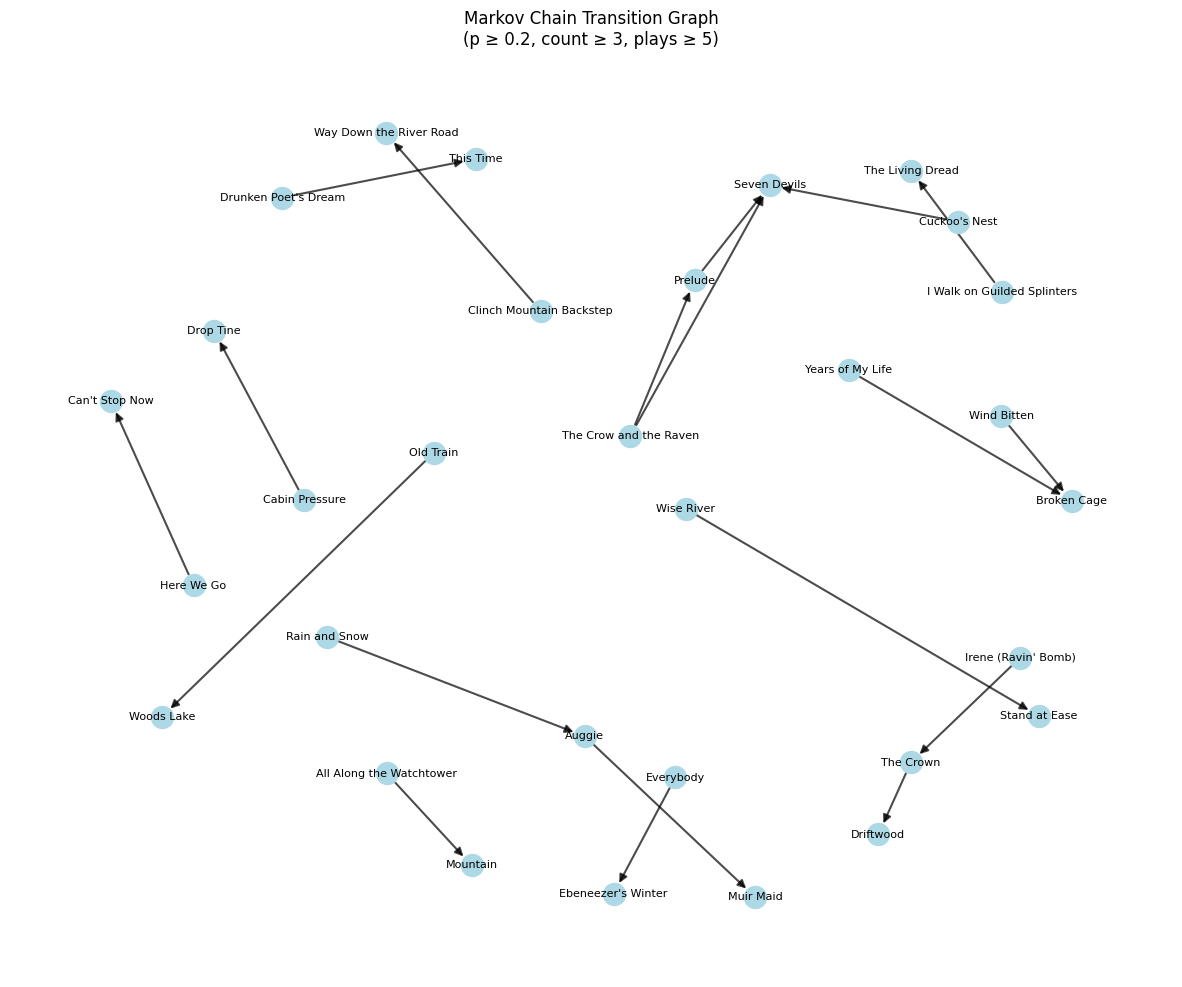

In [851]:
import networkx as nx
import matplotlib.pyplot as plt

min_p = 0.2             # Minimum probability for an edge to be drawn
min_count = 3           # Minimum transition count (A→B must appear at least this many times)
min_song_plays = 5      # Only include songs played at least this many times total

G = nx.DiGraph()

for song, counter in transition_counts.items():

    # FILTER 1: Song must be played enough times
    if song_play_counts[song] < min_song_plays:
        continue

    total = sum(counter.values())

    for nxt, count in counter.items():
        p = count / total

        # FILTER 2: Next song also must be played enough
        if song_play_counts[nxt] < min_song_plays:
            continue

        # FILTER 3: Only transitions with enough data + strong enough probability
        if count >= min_count and p >= min_p:
            G.add_edge(song, nxt, weight=p)

# Draw
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, k=0.4, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=250)
nx.draw_networkx_edges(G, pos, width=1.5, arrowsize=12, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title(f"Markov Chain Transition Graph\n(p ≥ {min_p}, count ≥ {min_count}, plays ≥ {min_song_plays})")
plt.axis('off')
plt.show()



In [852]:
max_p = 0
max_pair = None
for song, next_dict in transition_probs.items():
    for nxt, p in next_dict.items():
        if p > max_p:
            max_p = p
            max_pair = (song, nxt)

max_p, max_pair


(1.0, ('Morning Dew', 'Bertha'))

In [853]:
import pandas as pd

# Filter songs that appear enough times to be meaningful
min_song_plays = 5
songs = [s for s, c in song_play_counts.items() if c >= min_song_plays]

# Initialize a matrix of zeros
prob_matrix = pd.DataFrame(0.0, index=songs, columns=songs)

# Fill matrix with P(next_song | song)
for song in songs:
    if song in transition_probs:
        for nxt, p in transition_probs[song].items():
            if nxt in prob_matrix.columns:
                prob_matrix.loc[song, nxt] = p

prob_matrix.head()


,Covered Bridges,High on a Mountain Top,Years of My Life,The Quail,Colder Nights,Gypsy,Here We Go,Deal,Run for the Roses,Bertha,...,Red Haired Boy,Fall on My Knees,Reuben's Train,All Along the Watchtower,Blackberry Blossom,Kentucky Mandolin,Aeroplane,Panama,Intro,Ten
Covered Bridges,0.000000,0.080808,0.000000,0.030303,0.000000,0.010101,0.0,0.010101,0.0,0.000000,...,0.0,0.0,0.060606,0.0,0.0,0.0,0.0,0.010101,0.0,0.010101
High on a Mountain Top,0.034483,0.000000,0.068966,0.000000,0.000000,0.034483,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.034483,0.0,0.000000
Years of My Life,0.020408,0.000000,0.000000,0.020408,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
The Quail,0.000000,0.000000,0.000000,0.000000,0.013158,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
Colder Nights,0.000000,0.051282,0.025641,0.076923,0.000000,0.025641,0.0,0.000000,0.0,0.025641,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [854]:
from sklearn.decomposition import PCA

# Choose how many PCA dimensions you want:
# 2 for visualization (scatter plot), 5–10 for better clustering
n_components = 10

pca = PCA(n_components=n_components)
song_features = pca.fit_transform(prob_matrix.values)

song_features_df = pd.DataFrame(song_features, index=prob_matrix.index)

song_features_df.head()


,0,1,2,3,4,5,6,7,8,9
Covered Bridges,0.018498,0.018501,0.139994,0.047591,0.012109,-0.021211,-0.011222,0.006510,-0.006752,-0.024913
High on a Mountain Top,-0.009452,0.035626,0.094418,0.043251,0.024853,-0.039803,-0.022736,-0.006260,0.007052,0.009978
Years of My Life,-0.028970,-0.034753,0.030332,-0.092713,-0.182244,0.057727,0.195516,0.136518,0.043258,0.086789
The Quail,0.001498,-0.008309,0.021098,-0.041544,0.011804,0.005930,-0.016984,0.013489,-0.015049,-0.042624
Colder Nights,-0.014553,-0.012238,0.028026,-0.051675,-0.021953,0.014354,-0.075344,-0.007556,-0.022681,-0.001510


In [855]:
from sklearn.cluster import KMeans

k = 6  # number of segue families you want
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(song_features_df)

# attach cluster labels to each song
song_clusters = pd.DataFrame({
    "song": song_features_df.index,
    "cluster": clusters
}).set_index("song")

song_clusters.head(20)


,cluster
song,
Covered Bridges,1
High on a Mountain Top,5
Years of My Life,5
The Quail,5
Colder Nights,5
Gypsy,5
Here We Go,5
Deal,5
Run for the Roses,5


In [856]:
for c in range(k):
    print(f"\n--- Segue Family {c} ---")
    cluster_songs = song_clusters[song_clusters.cluster == c].index.tolist()
    for s in cluster_songs:
        print("  ", s)



--- Segue Family 0 ---
   nan
   Auggie
   Smokestack
   Dreaming With My Eyes Wide Open
   I'm Working on a Building
   Ball & Chain
   Brandy (You're a Fine Girl)

--- Segue Family 1 ---
   Covered Bridges
   Mountain
   In the Pines
   Transdermal Celebration
   Up on the Hill Where They Do the Boogie
   Waterford Son
   Blue Indian
   New Horizons
   Breed
   Everybody
   What the Night Brings
   Hey You
   The Boys of Summer
   Piper
   Pigs (Three Different Ones)
   I Walk on Guilded Splinters
   Reuben's Train
   Ten

--- Segue Family 2 ---
   Guilty
   Cleaning Windows
   Cold on the Shoulder
   Woods Lake
   The Crown
   Do It Again
   Pretty Daughter
   Tom Barrett
   Motorcycle
   Willy the Wandering Gypsy and Me
   Irene (Ravin' Bomb)
   What it Takes
   Unwanted Love
   White House Blues
   If You're Ever in Oklahoma
   Old Train
   Intro

--- Segue Family 3 ---
   New Speedway Boogie
   Prelude
   Welcome to Paradise
   Cuckoo's Nest
   The Crow and the Raven
   Ganja Sm

In [857]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
song_features_2d = pca_2d.fit_transform(prob_matrix.values)

vis_df = pd.DataFrame(song_features_2d, index=prob_matrix.index, columns=["PC1", "PC2"])
vis_df["cluster"] = song_clusters["cluster"]
vis_df.head()


,PC1,PC2,cluster
Covered Bridges,0.018498,0.018501,1
High on a Mountain Top,-0.009452,0.035626,5
Years of My Life,-0.028970,-0.034753,5
The Quail,0.001498,-0.008309,5
Colder Nights,-0.014553,-0.012238,5


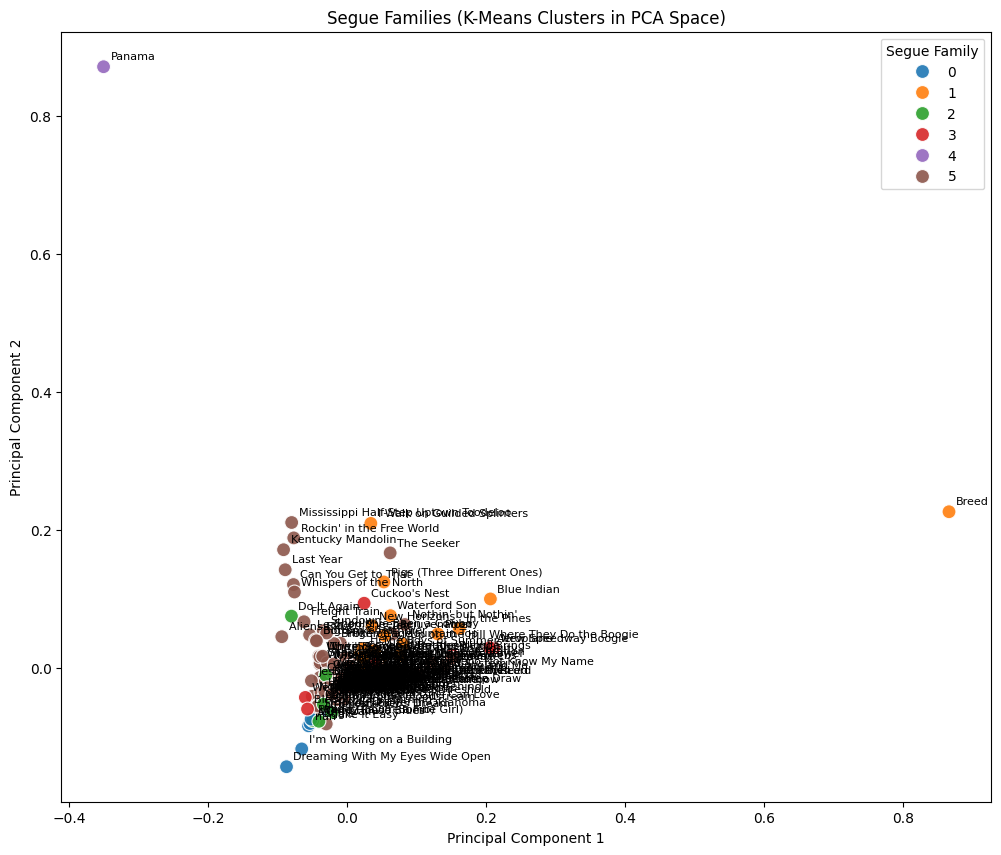

In [858]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

sns.scatterplot(
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    data=vis_df,
    s=100,
    alpha=0.9
)

for song, row in vis_df.iterrows():
    plt.text(row["PC1"] + 0.01, row["PC2"] + 0.01, song, fontsize=8)

plt.title("Segue Families (K-Means Clusters in PCA Space)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Segue Family")
plt.show()
